In [43]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import Dataset, DataLoader

In [44]:
N_SAMPLES = 100
NOISE_STD = .5

In [210]:
def gen_data(n_samples, ordered=False):
    
    if ordered:
        x = np.linspace(-7, 7, n_samples)
        
    else:
        x = np.random.uniform(-5, 5, n_samples)
    
    y = x**3/10 + np.sin(x)*5
    
    return x, y

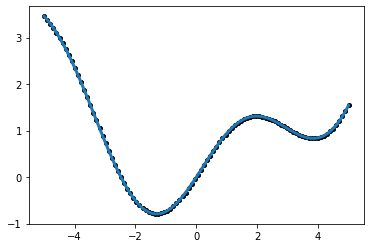

In [211]:
x = np.linspace(-5, 5, N_SAMPLES)
y = x**2/10 + np.sin(x)

plt.plot(x, y, linewidth=3)
plt.scatter(x, y, color='black', s=16)

In [212]:
class GenericDataset(Dataset):
    
    def __init__(self, n_batches, noise_std):
        super().__init__()
        
        self.n_batches = n_batches
        self.noise_std = noise_std
        
    def __len__(self):
        return self.n_batches
    
    def __getitem__(self, idx):
        
        context_x, context_y = gen_data(1)
        
        target_x, target_y = gen_data(1)
        
        return context_x, context_y+np.random.normal(0, 0.3, len(context_y)), target_x, target_y+np.random.normal(0, 0.3, len(context_y))

In [219]:
train_dataset = GenericDataset(100, NOISE_STD)
train_dataloader = DataLoader(train_dataset, batch_size = 32)

In [220]:
class Encoder(torch.nn.Module):
    
    def __init__(self, n_input, n_hidden, n_latent):
        super().__init__()
        
        self.linear1 = torch.nn.Linear(n_input, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, n_latent)
        
        self.linear3 = torch.nn.Linear(n_latent, n_latent+1)
        self.softplus =  torch.nn.Softplus()
        
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        
        # Aggregator
        x = torch.mean(x, axis=0).unsqueeze(0)
        
        # Project to a mean and standard deviation.
        x = self.relu(self.linear3(x))
        
        mean = x[:, :-1]
        standard_deviation = self.softplus(x[:, -1:])
        
        return mean, standard_deviation
    
class Decoder(torch.nn.Module):
    
    def __init__(self, latent_dim, n_input, n_output, n_hidden):
        super().__init__()
        
        self.n_output = n_output
        
        self.linear1 = torch.nn.Linear(latent_dim, n_hidden)
        self.linear2 = torch.nn.Linear(n_input, n_hidden)
        
        self.linear3 = torch.nn.Linear(n_hidden, n_hidden)
        self.linear4 = torch.nn.Linear(n_hidden, n_output*2)
        
        self.relu = torch.nn.ReLU()
        self.softplus = torch.nn.Softplus()
        
    def forward(self, latent, x):
        
        x = self.relu(self.linear1(latent)) + self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        
        mean = x[:, :self.n_output]
        standard_deviation = self.softplus(x[:,self.n_output:])
        
        n_batches = mean.shape[0]
        
        output_distribution = torch.distributions.normal.Normal(mean,
                                                                standard_deviation)
        
        return output_distribution
    
class NeuralProcess(torch.nn.Module):
    
    def __init__(self, encoder, decoder, latent_dim):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, context_points, inputs):
        
        mean, standard_deviation = self.encoder(context_points)
        
        sampled_latent = torch.randn(1, mean.shape[1])*standard_deviation + mean
        
        output_distribution = self.decoder(sampled_latent, inputs)
        
        return output_distribution

In [221]:
LATENT_DIM = 128
N_HIDDEN = 128*4
N_INPUT = 1
N_OUTPUT = 1

encoder = Encoder(N_INPUT*2, N_HIDDEN, LATENT_DIM)
decoder = Decoder(LATENT_DIM, N_INPUT, N_OUTPUT, N_HIDDEN)
neural_process = NeuralProcess(encoder, decoder, LATENT_DIM).double()

In [225]:
N_EPOCHS = 200

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_process.parameters(), lr=0.0001)

for epoch in range(N_EPOCHS):
    
    rmse_vals = []
    
    for context_x, context_y, target_x, target_y in train_dataloader:
        
        encoder_input = torch.cat([context_x, context_y], axis=1)

        output_distribution = neural_process(encoder_input, target_x)
        
        loss = torch.mean(-output_distribution.log_prob(target_y)) #criterion(target_y, prediction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rmse_vals.append(loss.item())
        
    clear_output(wait=True)
    print(f"Epoch {epoch+1} RMSE: {np.mean(rmse_vals)}")

Epoch 200 RMSE: 1.1983671752625948


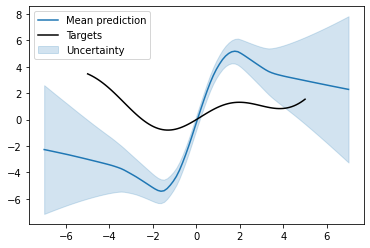

In [226]:
pred_x, pred_y = gen_data(100, ordered=True)

prediction_distribution = neural_process(encoder_input, torch.Tensor(pred_x.reshape(-1, 1)).double())

prediction = prediction_distribution.mean
prediction = prediction.reshape(-1).detach().cpu().numpy()

uncertainty = prediction_distribution.stddev
uncertainty = uncertainty.reshape(-1).detach().cpu().numpy()

plt.plot(pred_x, prediction, color='tab:blue', label="Mean prediction")
plt.fill_between(pred_x, prediction - 1.97*uncertainty, prediction + 1.97*uncertainty, alpha=0.2, 
                 color='tab:blue', label="Uncertainty")
plt.plot(x, y, color='black', label="Targets")
plt.legend()
plt.show()